# **Cantoría Evaluation**

Developed by André Paiva

Based on Cantoría Dataset and papers by Helena Cuesta and Emilia Gómez

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import sscs

2023-07-20 02:11:03.241608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 02:11:07,036	INFO worker.py:1636 -- Started a local Ray instance.
sh: 1: load_ext: not found


2023-07-20 02:11:08.739615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-20 02:11:08.744144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-20 02:11:08.744223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-20 02:11:08.746074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-20 02:11:08.746113: I tensorflow/compile

1/1 [==============================] - 0s 221ms/step


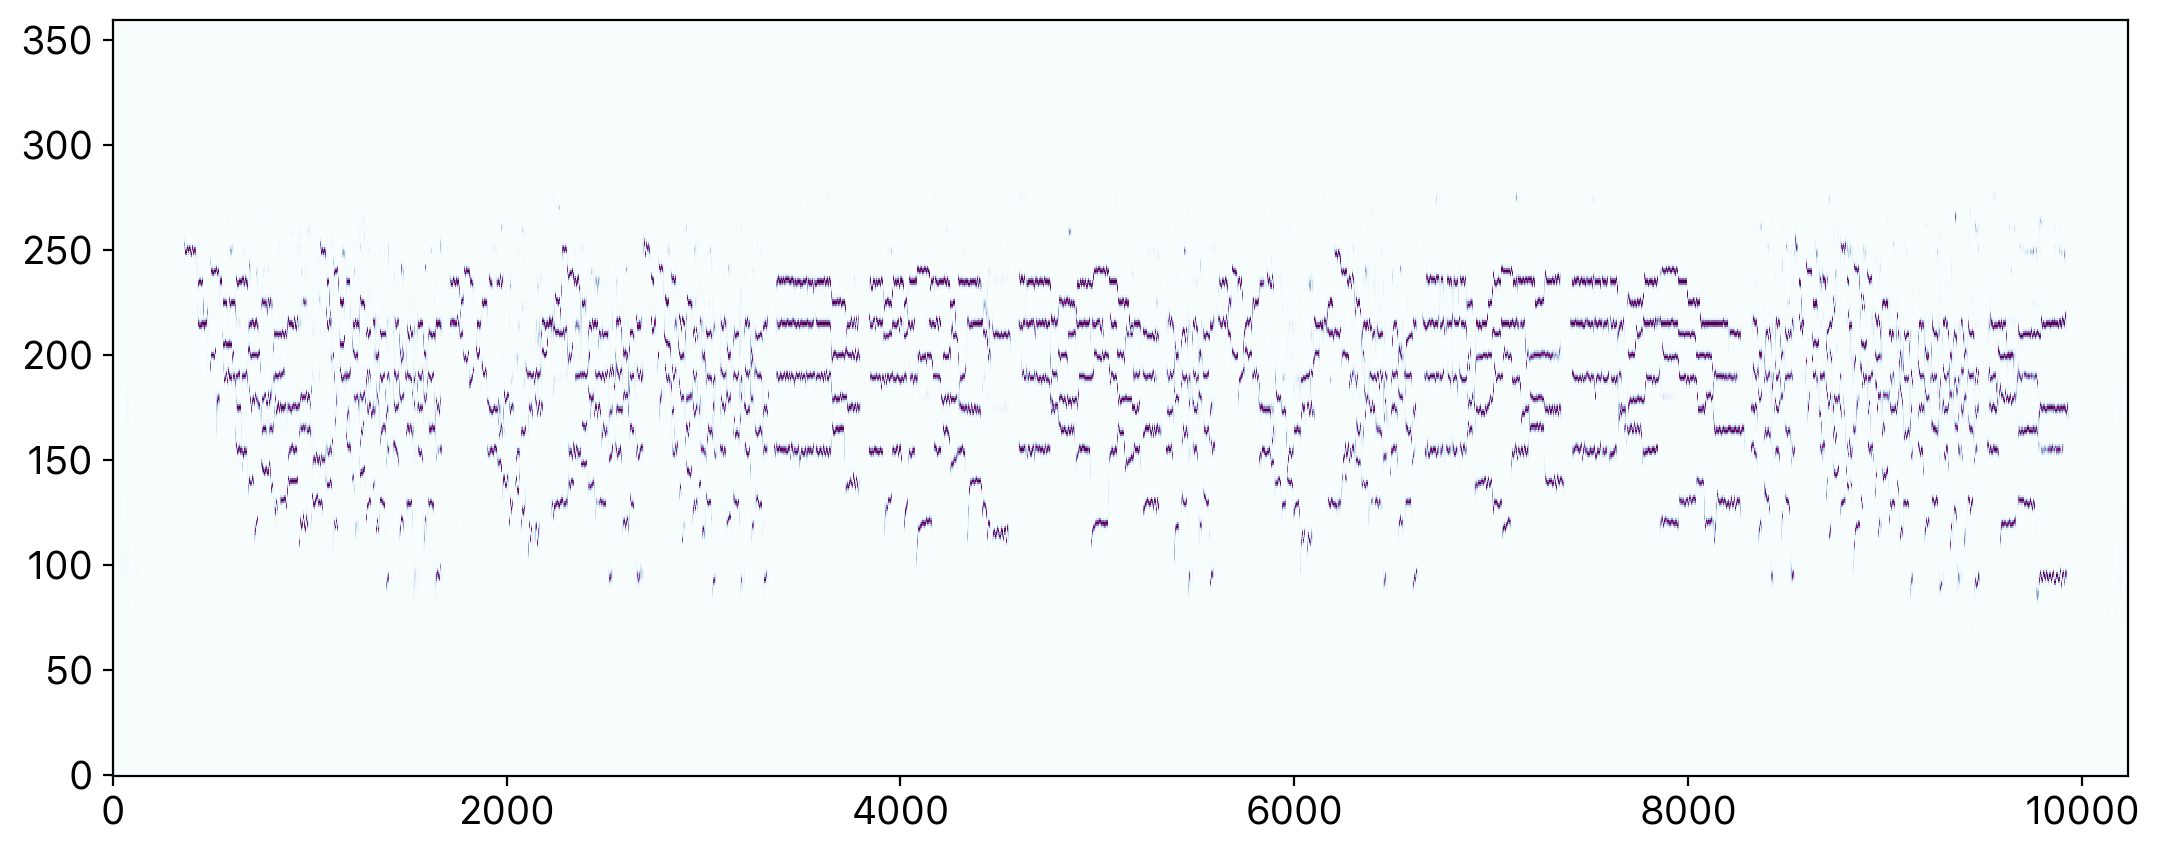

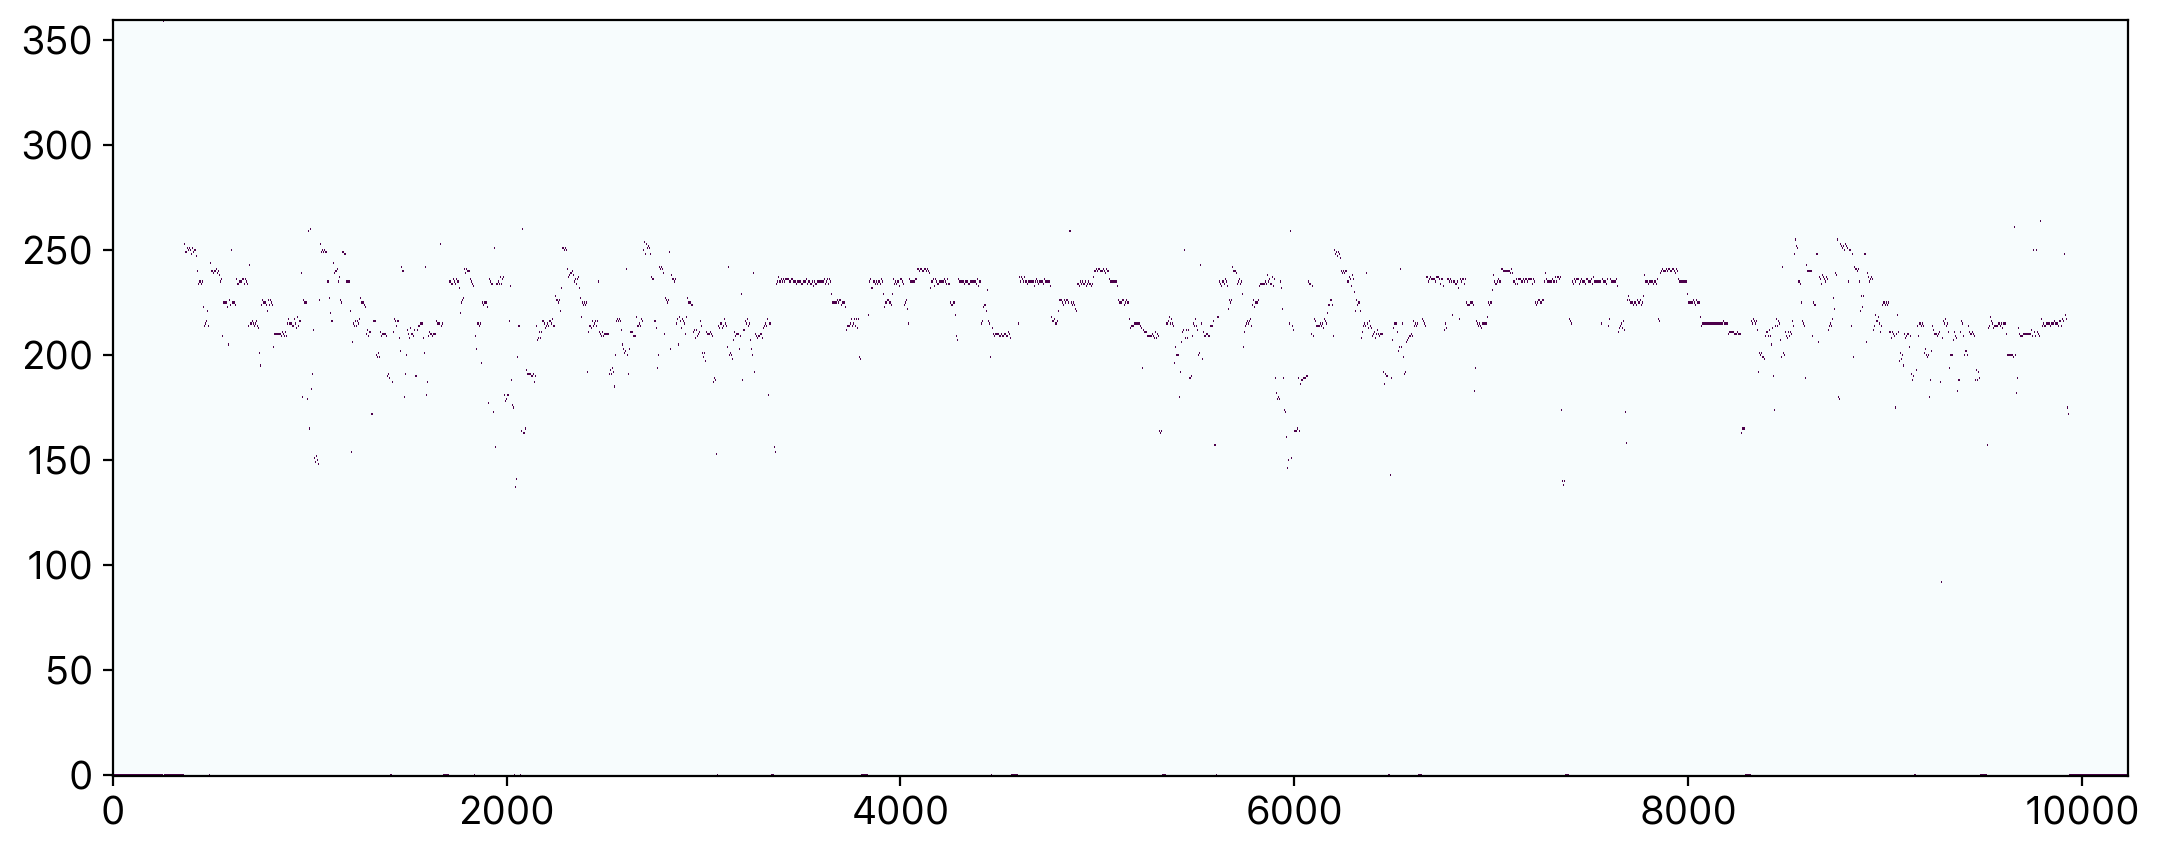

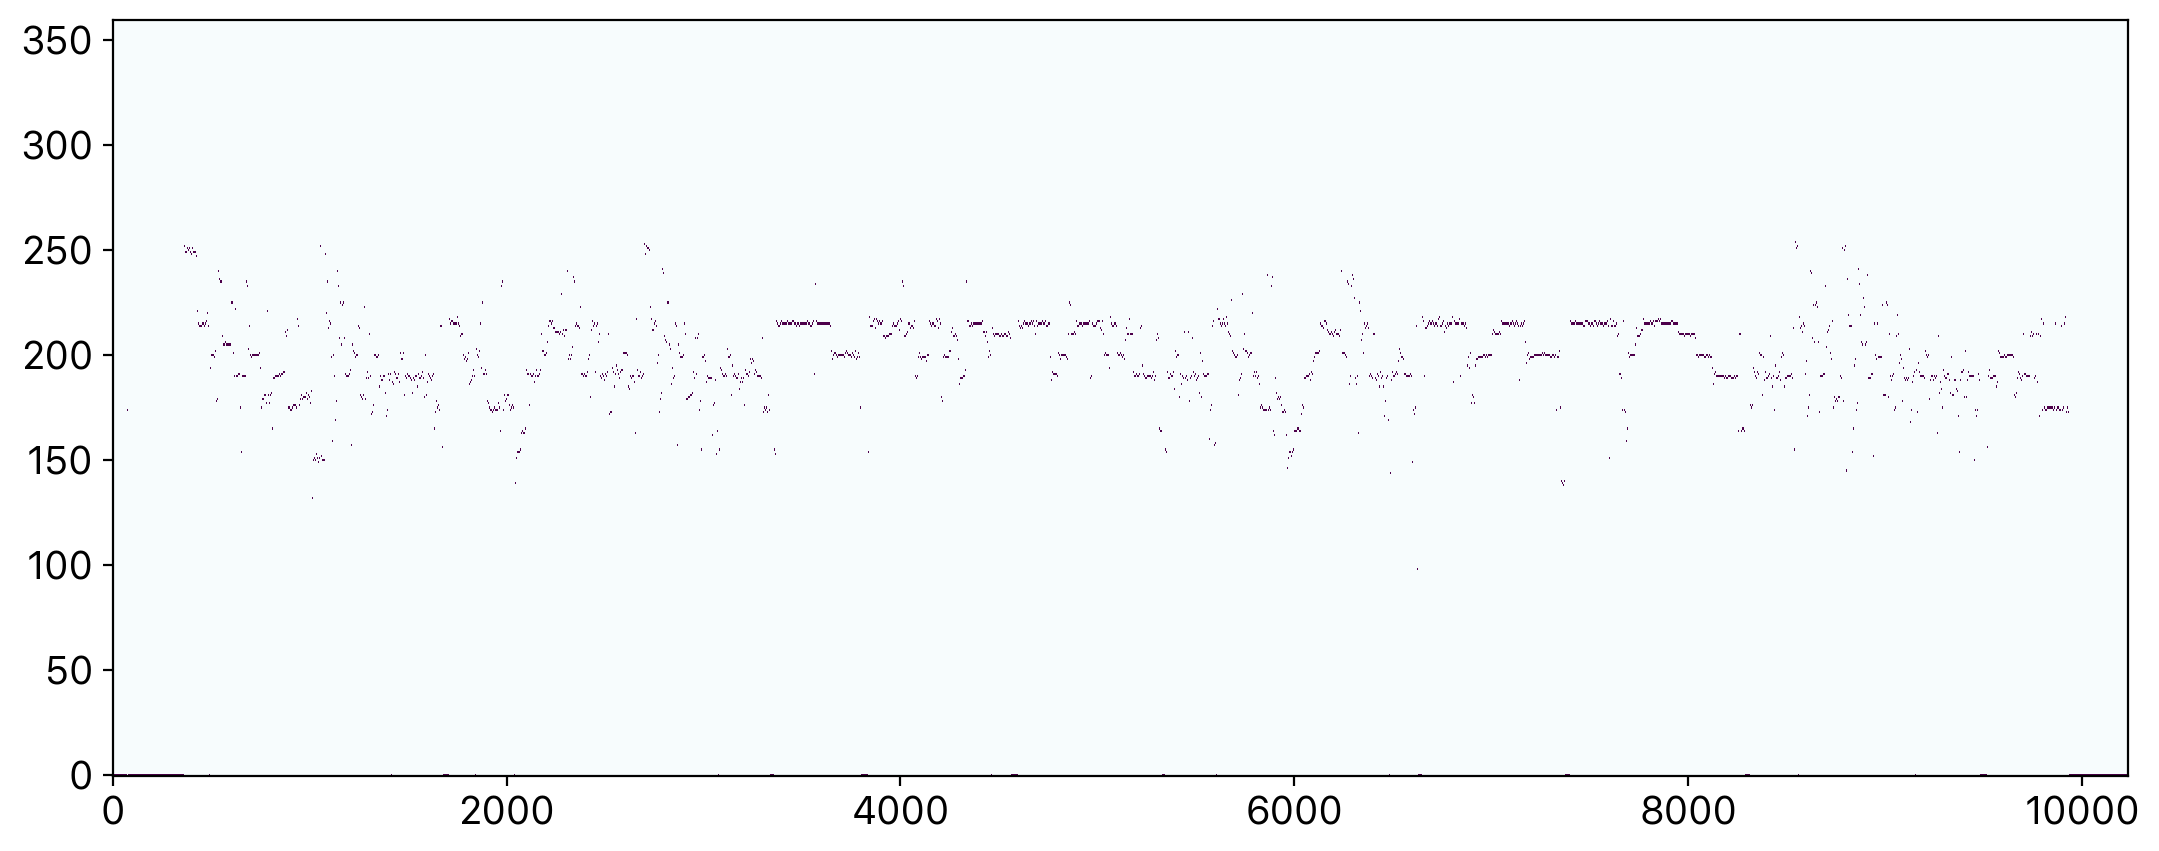

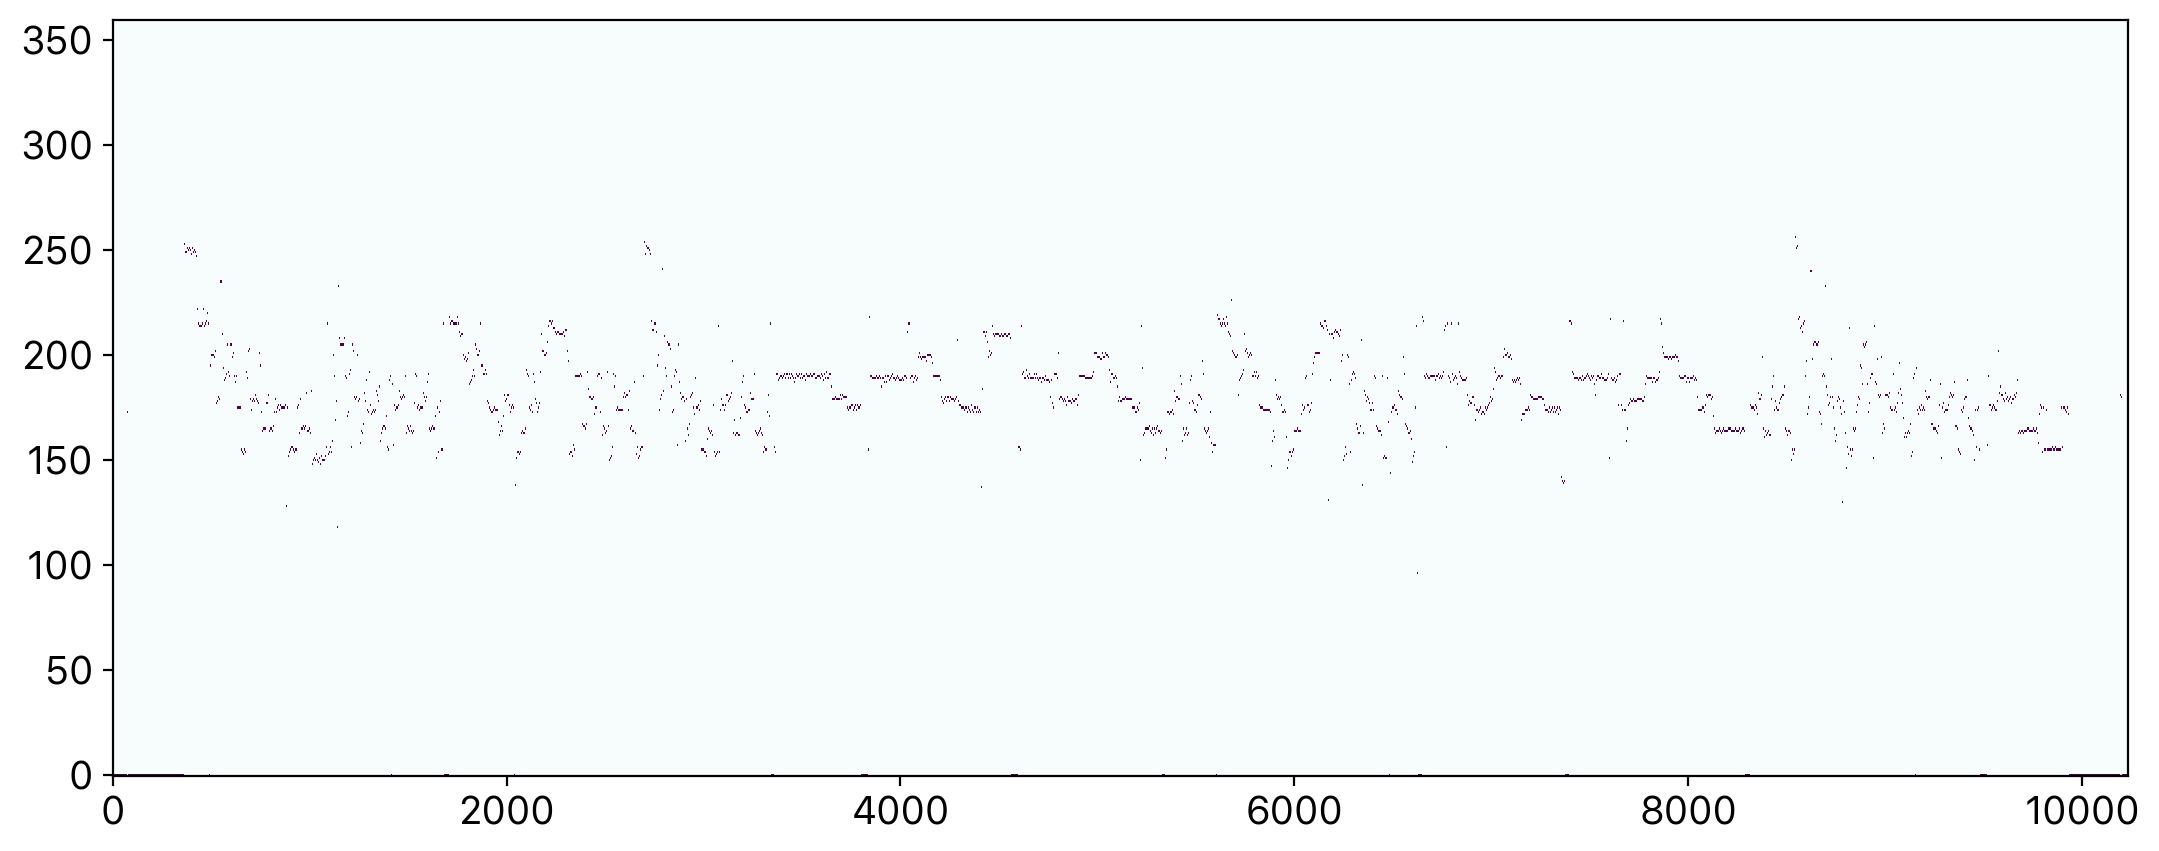

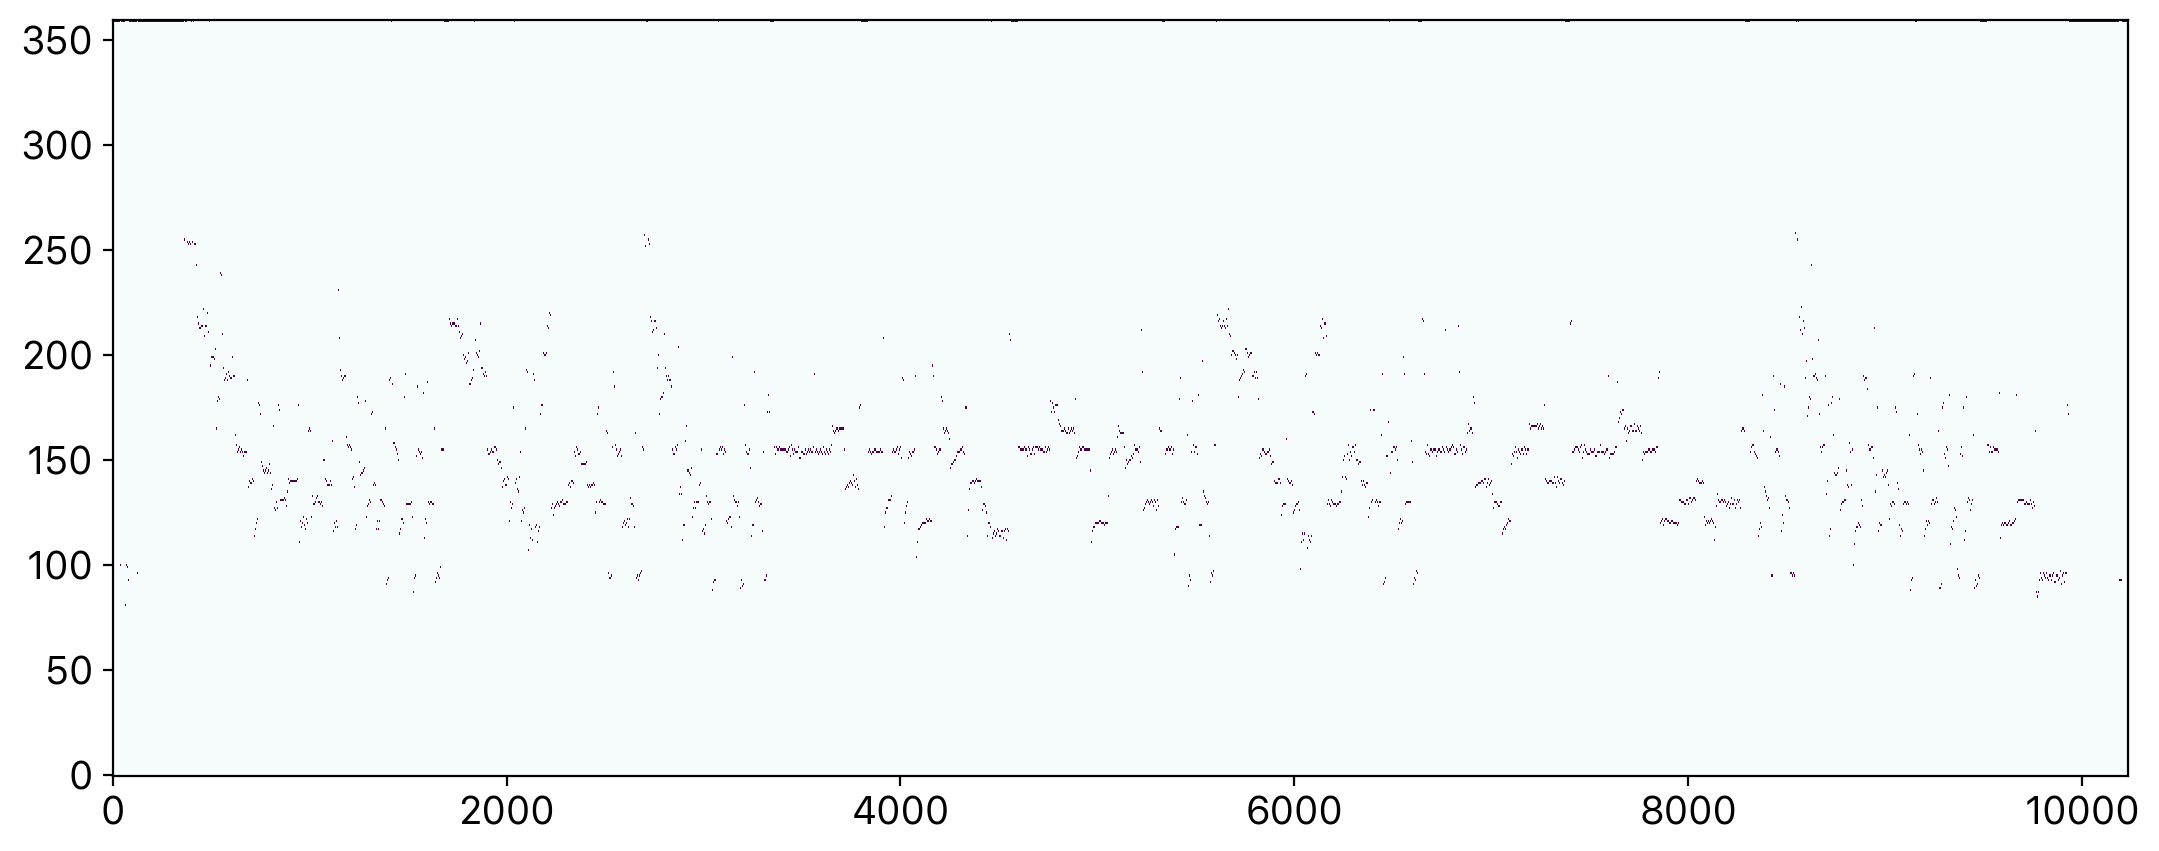

In [2]:
df = pd.read_hdf('Datasets/Cantoria/Audio/Cantoria_CEA_Mix.h5', key='mix', mode='r')
mix = df.to_numpy().T

ckpt_dir = './Checkpoints/mask_voas_v2_treino1.keras'
model = sscs.mask_voas_cnn_v2_model()
sscs.load_weights(model, ckpt_dir=ckpt_dir)

splits = mix.shape[1]//256
splits_diff = 256 - (mix.shape[1] - splits * 256)
fill = np.zeros((360, splits_diff))
mix_filled = np.concatenate((np.copy(mix), fill), axis=1)
mix_filled = np.reshape(mix_filled, (360, -1, 256, 1)).transpose((1, 0, 2, 3))
batches = math.ceil(mix_filled.shape[0]/24)

s_pred_result = np.zeros((0, 360, 256))
a_pred_result = np.zeros((0, 360, 256))
t_pred_result = np.zeros((0, 360, 256))
b_pred_result = np.zeros((0, 360, 256))

for i in range(batches):
    s_pred, a_pred, t_pred, b_pred = model.predict(mix_filled[i*24:(i+1)*24])
    s_pred_result = np.append(s_pred_result, s_pred, axis=0)
    a_pred_result = np.append(a_pred_result, a_pred, axis=0)
    t_pred_result = np.append(t_pred_result, t_pred, axis=0)
    b_pred_result = np.append(b_pred_result, b_pred, axis=0)

s_pred_result = sscs.prediction_postproc(s_pred_result, gaussian_blur=False)[:, :mix.shape[1]]
a_pred_result = sscs.prediction_postproc(a_pred_result, gaussian_blur=False)[:, :mix.shape[1]]
t_pred_result = sscs.prediction_postproc(t_pred_result, gaussian_blur=False)[:, :mix.shape[1]]
b_pred_result = sscs.prediction_postproc(b_pred_result, gaussian_blur=False)[:, :mix.shape[1]]

sscs.plot(mix)
sscs.plot(s_pred_result)
sscs.plot(a_pred_result)
sscs.plot(t_pred_result)
sscs.plot(b_pred_result)
sscs.song_to_midi(s_pred_result, a_pred_result, t_pred_result, b_pred_result, './MIDI/cantoria.mid')